<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/ML_AI24_HT7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 7: Fraud Detection Competition**

Добро пожаловать на финальное домашнее задание курса! Домашнее задание направлено на систематизацию всех знаний, полученных в процессе учебы.

В нём Вы потренируетесь применять навыки построения пайплайнов машинного обучения, приобретенные в курсе от точки разведочного анализа данных до построения и валидации моделей машинного обучения.

## **Задача**
**Вы будете решать задачу определения фрода:**

https://www.kaggle.com/competitions/fraud-detection-24

**Вам нужно будет:**
- в jupyter notebook провести исследование данных;
- в нём же построить модели и оценить их качество;
- отправить посылку на Kaggle.

Более подробное описание шагов - в ноутбуке ниже.

## **Оценивание и баллы**
- В EDA и во всей работе будут оцениваться полнота и **выводы**;
- При обучении моделей старайтесь обоснованно подходить к их выбору, избегая простого перебора;

**Максимальный балл** - 10 (+ бонусы за Kaggle, см. ниже).




# **Базовое решение и пример формирования файла под submission**


In [1]:
!wget --no-check-certificate 'https://www.dropbox.com/s/5iuef7c9ljj84t6/train_transaction.csv?dl=0' -O train_transaction.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/cmy01z5fw7ohlmd/train_identity.csv?dl=0' -O train_identity.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/7thqkuxnwsa7njj/test_transaction.csv?dl=0' -O test_transaction.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/b40nvbb9e2usd5w/test_identity.csv?dl=0' -O test_identity.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/arkyoz0bel8z4d2/sample_submission.csv?dl=0' -O sample_submission.csv

^C
--2025-09-30 22:16:19--  https://www.dropbox.com/s/cmy01z5fw7ohlmd/train_identity.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/by3x8jnqtllqpuh648gum/train_identity.csv?rlkey=mjcnbnj1kyecwl3ar54yxg9fu&dl=0 [following]
--2025-09-30 22:16:22--  https://www.dropbox.com/scl/fi/by3x8jnqtllqpuh648gum/train_identity.csv?rlkey=mjcnbnj1kyecwl3ar54yxg9fu&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7afc4efaad05e4ee196d909e6f.dl.dropboxusercontent.com/cd/0/inline/CyVYHTnmj3Y0iy8Uyb7dcQT9ObpcGLodM_5Au3A6OZgUBPljLPE-qQt3c0yabdg4bV7WSXDO7bkpPiQTH_-dM7X7vsbkxYzR54CSsgIk6qksAwBZTSSCc7IKGxR9-7_5kZoE2oBZ3tSANDdjAFNOs91x/file# [following]
--2025-09-30 22:16:23--  https://uc7afc4efaad05e4ee196d909e6f.dl.dropboxusercontent.com/cd/

In [217]:
!pip install catboost -q

In [5]:
from catboost import CatBoostClassifier
import pandas as pd
import os
from tqdm import tqdm

import numpy as np

INPUT_DIR = '.'

train_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'train_transaction.csv'))
train_identity = pd.read_csv(os.path.join(INPUT_DIR, 'train_identity.csv'))
test_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'test_transaction.csv'))
test_identity = pd.read_csv(os.path.join(INPUT_DIR, 'test_identity.csv'))
sample_submission = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))

df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')

df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')

In [6]:
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_train.shape, df_test.shape

((417559, 432), (172981, 431))

In [74]:
object_cols = []
for idx, col in tqdm(enumerate(df_train.columns.drop('isFraud'))):
    if df_train[col].dtype == 'O':
      object_cols.append(idx)

431it [00:00, 79538.24it/s]


In [76]:
X_train = df_train.drop('isFraud', axis=1)
#X_train = X_train.fillna('')
y_train = df_train['isFraud'].values

In [75]:


cb = CatBoostClassifier(iterations=3)
cb.fit(X_train, y_train, object_cols, )

predictions = cb.predict_proba(df_test.fillna(''))

sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions[:, 0]})
sub.head()

sub.to_csv('submission_baseline.csv', index=False)

Learning rate set to 0.5


CatBoostError: (Error 60: Operation timed out) util/system/file.cpp:936: can't open "catboost_info/catboost_training.json" with mode CreateAlways (0x00000004)

In [5]:
# Сохранение submission
sub.to_csv('submission_baseline.csv', index=False)

![baseline_check](https://storage.yandexcloud.net/infections-project-datasets/sub_baseline.png)

### **Примечания:**

**1. Оценка качества и Submission File**
- Ответом является число от 0 до 1, метрикой качества - AUC-ROC.
- Структура Submission File:
 - для каждого значения *TransactionID* в тестовых данных вы должны предсказать **вероятность** для столбца *isFraud*.
 - в файле у вас должно быть две колонки: `TransactionID` и`isFraud`  **для каждой транзакции в датасете**.

**2. Объем данных**

Поскольку набор данных объемный, могут быть проблемы с переполнением памяти в Collab. Для решения проблемы можете использовать функцию из [этого ноутбука](https://colab.research.google.com/drive/18u75eyFGEoyeWJ_MbsLkcPa6gv2tNI8G#scrollTo=V2L1Nl5CTMMl), разобравшись, что она делает с данными.

In [9]:
def reduce_mem_usage(df):
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in tqdm(df.columns):
        if df[col].dtype != object:  # Exclude strings

            # make variables for Int, max and min
            IsInt = False
            col_max_value = df[col].max()
            col_min_value = df[col].min()

            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(col_min_value - 1, inplace=True)

            # test if column can be converted to an integer
            col_as_int = df[col].fillna(0).astype(np.int64)
            diff = (df[col] - col_as_int)
            diff = diff.sum()
            if np.abs(diff) < 0.01:
                IsInt = True

            # Make Integer/unsigned Integer datatypes
            if pd.api.types.is_integer_dtype(df[col]):
                if col_min_value >= 0:
                    if col_max_value < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif col_max_value < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif col_max_value < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if col_min_value > np.iinfo(np.int8).min and col_max_value < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif col_min_value > np.iinfo(np.int16).min and col_max_value < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif col_min_value > np.iinfo(np.int32).min and col_max_value < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif col_min_value > np.iinfo(np.int64).min and col_max_value < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    

            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)

    return df, NAlist

In [10]:
df_train, df_train_NAlist = reduce_mem_usage(df_train)
df_test, df_test_NAlist = reduce_mem_usage(df_test)

  0%|          | 0/432 [00:00<?, ?it/s]/var/folders/1l/pqz7l_2x14sddt6yj80vz_k80000gn/T/ipykernel_7472/3832630977.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(col_min_value - 1, inplace=True)
  6%|▋         | 27/432 [00:00<00:01, 260.20it/s]/var/folders/1l/pqz7l_2x14sddt6yj80vz_k80000gn/T/ipykernel_7472/3832630977.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace met

# **Задание 1 (2 балла)**

Проведите EDA (разведочный анализ данных):
* проанализируйте признаки, их особенности и связь с целевой переменной
* проанализируйте целевую переменную
* оцените степень попарной взаимосвязи признаков, а также связи признаков и целевой переменной
* по результатам исследований сделайте необходимую обработку данных (удаление дублей, работа с пропусками, с категориальными столбцами (если они есть), работа с аномалиями, другие преобразования признаков)

Важно, что EDA всегда сопровождается выводами - не забудьте об этом.

In [6]:
df_train

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,68.500,W,13926,NaN,150.0,discover,142.0,credit,315.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,29.000,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,59.000,W,4663,490.0,150.0,visa,166.0,debit,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,50.000,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,50.000,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417554,0,335.000,W,2538,476.0,150.0,visa,166.0,debit,126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417555,0,160.500,W,6019,583.0,150.0,visa,226.0,credit,269.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417556,0,230.079,C,5059,138.0,200.0,visa,226.0,debit,NaN,...,chrome 65.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-A320FL Build/NRD90M
417557,0,105.000,W,6697,111.0,150.0,visa,195.0,debit,299.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 1. Исследуем целевую переменную

In [366]:
df_train.isFraud.isna().sum()

0

<Axes: xlabel='isFraud', ylabel='Count'>

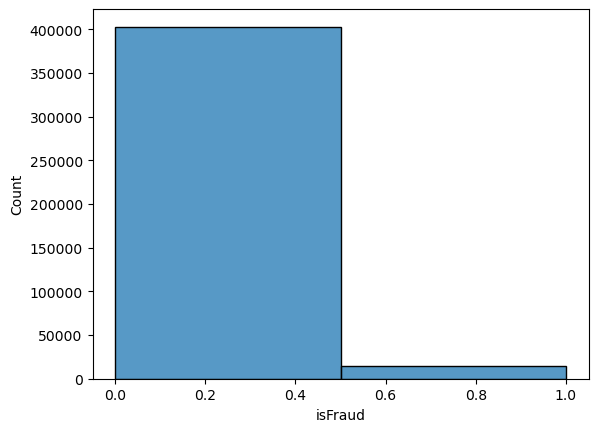

In [367]:
sns.histplot(df_train.isFraud, bins=2)

**Вывод:** мы видем ярко выраженный дисбаланс классов
Это обязывает нас:
1) внимательно относиться к метрикам;
2) обращать внимание на работу с пропусками и их ассоциацию с целевой переменной - незаполненность признака может быть информативной

#### 2. Проведем исследование по группам признаков, начнем с категориальных

In [368]:
cat_features = df_train.select_dtypes(include=["object", "category"]).columns.tolist()
cat_features

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_15',
 'id_16',
 'id_23',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo']

В EDA я рассматривал данные в следующем сеттинге: просмотр количества пропусков, взаимосвязь с целевой переменной. Для оценки взаимосвязи использовал метод [Cramer V](https://stackoverflow.com/questions/20892799/using-pandas-calculate-cramérs-coefficient-matrix).

In [369]:
import numpy as np
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import seaborn as sns

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))    
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def categorical_target_association(df, cat_cols, target="isFraud"):
    results = []
    for col in cat_cols:
        confusion = pd.crosstab(df[col], df[target])
        cv = cramers_v(confusion)
        results.append((col, cv))
    return pd.DataFrame(results, columns=["feature", "cramers_v"]).sort_values("cramers_v", ascending=False)

def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * mis_val / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'}
    )
    mis_val_table = mis_val_table[mis_val_table["Missing Values"]]
    mis_val_table = mis_val_table.sort_values('% of Total Values', ascending=False).round(1)
    return mis_val_table


def missing_values_report(df, columns):
    df_sub = df[columns]
    mis_val = df_sub.isnull().sum()
    mis_val_percent = 100 * mis_val / len(df_sub)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table = mis_val_table.rename(
        columns={0: 'abs', 1: 'percent'}
    )
    mis_val_table = mis_val_table[mis_val_table["abs"] > 0]
    mis_val_table = mis_val_table.sort_values('percent', ascending=False).round(1)
    
    print("Количество пропусков:")
    display(mis_val_table)


    plt.figure(figsize=(12,6))
    sns.heatmap(df_sub.isnull(), cbar=False, yticklabels=False)
    plt.title("Heatmap пропусков")
    plt.show()

##### Группа 1

In [9]:
cat_cols_1 = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo']

In [371]:
df_train[cat_cols_1].describe(include='object')

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,DeviceType,DeviceInfo
count,417559,416730,416733,352649,103820,108124,91959
unique,5,4,4,59,60,2,1551
top,W,visa,debit,gmail.com,gmail.com,desktop,Windows
freq,301297,272753,306554,160974,43010,66324,36841


Количество пропусков:


,abs,percent
DeviceInfo,325600,78.0
R_emaildomain,313739,75.1
DeviceType,309435,74.1
P_emaildomain,64910,15.5
card2,6563,1.6
card5,2981,0.7
card4,829,0.2
card6,826,0.2
card3,821,0.2


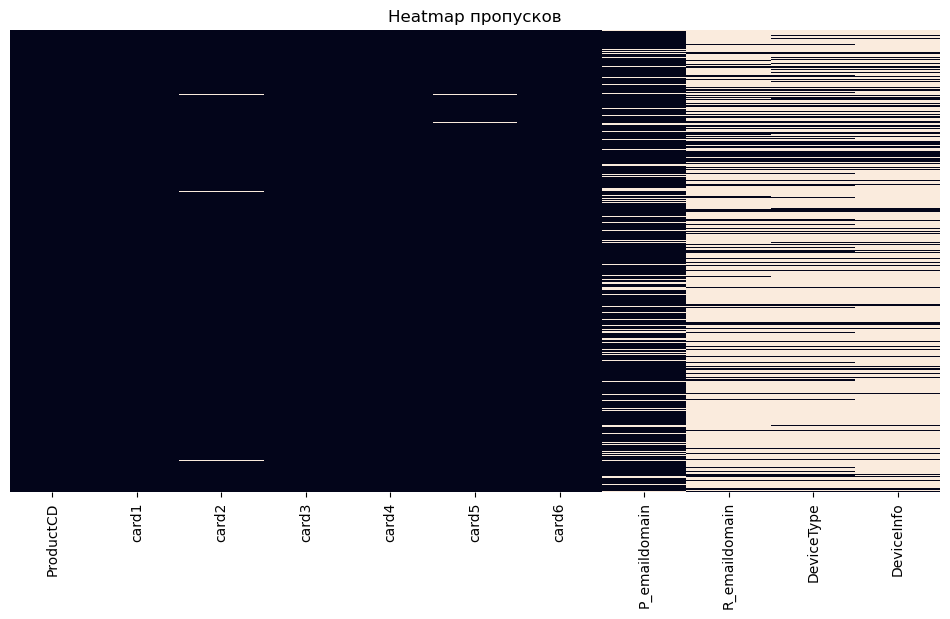

In [372]:
missing_values_report(df_train, cat_cols_1)

In [373]:
assoc = categorical_target_association(df_train, cat_cols_1, target="isFraud")
print(assoc)

          feature  cramers_v
10     DeviceInfo   0.401795
1           card1   0.319571
2           card2   0.222997
3           card3   0.166510
0       ProductCD   0.160831
8   R_emaildomain   0.155738
5           card5   0.122731
6           card6   0.100250
7   P_emaildomain   0.086562
9      DeviceType   0.071437
4           card4   0.018664


In [374]:
df_train['DeviceInfo'] = df_train.DeviceInfo.fillna('unknown')
df_test['DeviceInfo'] = df_test.DeviceInfo.fillna('unknown')

In [375]:
df_train.groupby(['DeviceInfo', 'isFraud']).agg({'card1':'count'}).sort_values(by=['isFraud', 'card1'], ascending=False)

,,card1
DeviceInfo,isFraud,
unknown,1,8436
Windows,1,2255
iOS Device,1,972
hi6210sft Build/MRA58K,1,180
MacOS,1,174
...,...,...
verykool,0,1
verykoolS5019,0,1
verykools5034,0,1


**Вывод:** мы видим, что у признака `DeviceInfo` самая высокая корелляция с таргетом. В то же время, это лидер по количеству пропущенных значений. Заменим в нем пропуски на *unknown* категорию, то же преобразование проведем в тестовом датасете. Аналогичным образом поступим и с другими фичами, чья корелляция с целевой перемнной *<0.1*, остальные дропнем.

In [376]:
df_train['card1'] = df_train.card1.fillna('unknown')
df_test['card1'] = df_test.card1.fillna('unknown')

df_train['card2'] = df_train.card2.fillna('unknown')
df_test['card2'] = df_test.card2.fillna('unknown')

df_train['card3'] = df_train.card3.fillna('unknown')
df_test['card3'] = df_test.card3.fillna('unknown')

df_train['card4'] = df_train.card3.fillna('unknown')
df_test['card4'] = df_test.card3.fillna('unknown')

df_train['card5'] = df_train.card3.fillna('unknown')
df_test['card5'] = df_test.card3.fillna('unknown')

df_train['card6'] = df_train.card3.fillna('unknown')
df_test['card6'] = df_test.card3.fillna('unknown')

df_train['ProductCD'] = df_train.ProductCD.fillna('unknown')
df_test['ProductCD'] = df_test.ProductCD.fillna('unknown')

df_train['R_emaildomain'] = df_train.R_emaildomain.fillna('unknown')
df_test['R_emaildomain'] = df_test.R_emaildomain.fillna('unknown')

df_train['card6'] = df_train.card6.fillna('unknown')
df_test['card6'] = df_test.card6.fillna('unknown')

df_train = df_train.drop(columns=['P_emaildomain', 'DeviceType'])
df_test = df_test.drop(columns=['P_emaildomain', 'DeviceType'])

##### Группа 2

In [377]:
cat_cols_2 = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

In [378]:
df_train[cat_cols_2].describe(include='object')

,M1,M2,M3,M4,M5,M6,M7,M8,M9
count,194116,194116,194116,215646,165564,288001,139491,139495,139495
unique,2,2,2,3,2,2,2,2,2
top,T,T,T,M0,F,F,F,F,T
freq,194098,173868,152682,136257,91343,155687,120729,88400,117695


Количество пропусков:


,abs,percent
M7,278068,66.6
M8,278064,66.6
M9,278064,66.6
M5,251995,60.3
M1,223443,53.5
M2,223443,53.5
M3,223443,53.5
M4,201913,48.4
M6,129558,31.0


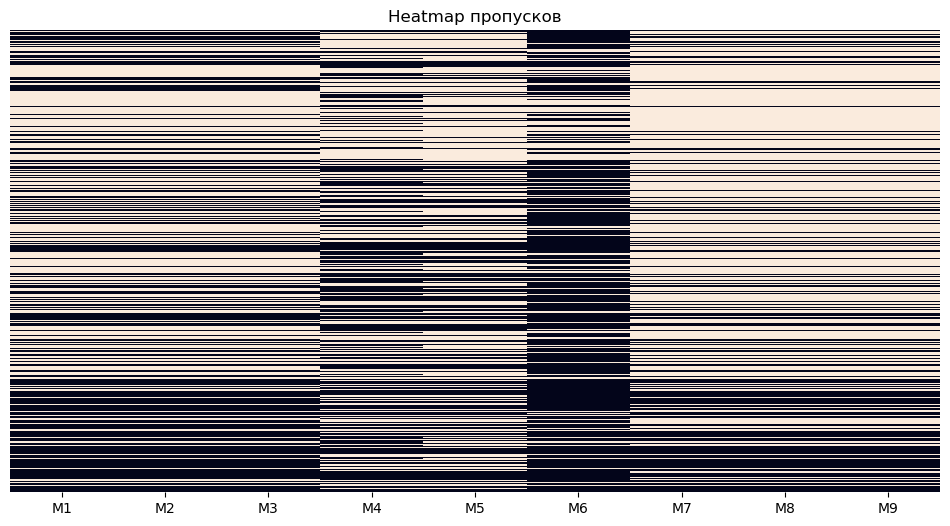

In [379]:
missing_values_report(df_train, cat_cols_2)

In [380]:
assoc = categorical_target_association(df_train, cat_cols_2, target="isFraud")
print(assoc)

  feature  cramers_v
3      M4   0.136929
2      M3   0.040041
4      M5   0.036335
1      M2   0.033838
8      M9   0.033179
5      M6   0.023133
7      M8   0.018090
6      M7   0.006541
0      M1   0.000000


**Выводы:** единственный признак с приличной корелляцией с таргетом - `M4`, оставим только его, заполнив пропуски как *unknown*. Остальные - дропнем в обоих датасетах.

In [381]:
df_train['M4'] = df_train.M4.fillna('unknown')
df_test['M4'] = df_test.M4.fillna('unknown')

df_train = df_train.drop(columns=['M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9'])
df_test = df_test.drop(columns=['M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9'])

##### Группа 3

In [382]:
cat_cols_3 = ['id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

In [383]:
df_train[cat_cols_3].describe(include='object')

,id_12,id_15,id_16,id_23,id_27,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38
count,110666,108273,99590,3954,3954,108273,108273,62096,107961,57819,62168,108273,108273,108273,108273
unique,2,3,2,3,2,2,2,71,110,183,4,2,2,2,2
top,NotFound,Found,NotFound,IP_PROXY:TRANSPARENT,Found,Found,Found,Windows 10,chrome 63.0,1920x1080,match_status:2,T,F,T,T
freq,96010,50788,50090,2635,3945,57753,56554,16078,21821,13466,46931,62152,102536,84398,57779


In [384]:
df_train[cat_cols_3].describe(include='object')

,id_12,id_15,id_16,id_23,id_27,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38
count,110666,108273,99590,3954,3954,108273,108273,62096,107961,57819,62168,108273,108273,108273,108273
unique,2,3,2,3,2,2,2,71,110,183,4,2,2,2,2
top,NotFound,Found,NotFound,IP_PROXY:TRANSPARENT,Found,Found,Found,Windows 10,chrome 63.0,1920x1080,match_status:2,T,F,T,T
freq,96010,50788,50090,2635,3945,57753,56554,16078,21821,13466,46931,62152,102536,84398,57779


Количество пропусков:


,abs,percent
id_23,413605,99.1
id_27,413605,99.1
id_33,359740,86.2
id_30,355463,85.1
id_34,355391,85.1
id_16,317969,76.1
id_31,309598,74.1
id_15,309286,74.1
id_28,309286,74.1
id_29,309286,74.1


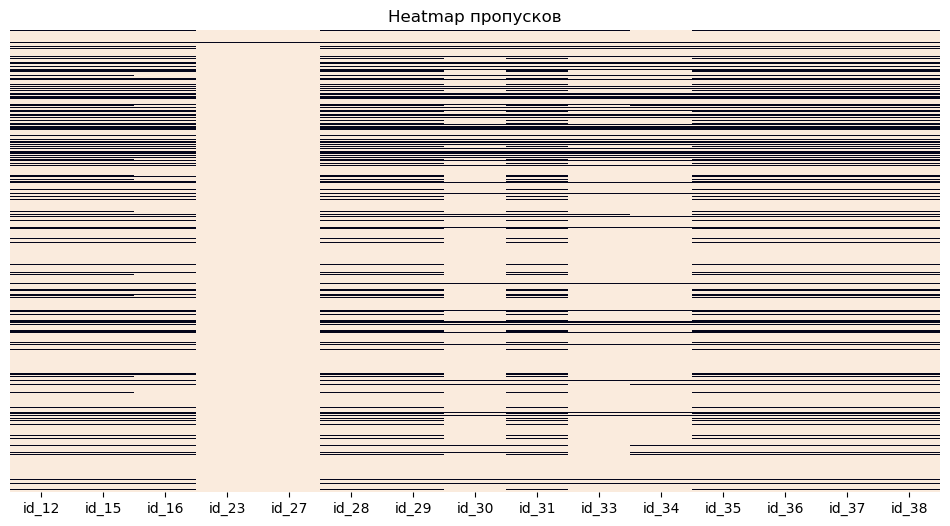

In [385]:
missing_values_report(df_train, cat_cols_3)

In [386]:
assoc = categorical_target_association(df_train, cat_cols_3, target="isFraud")
print(assoc)

   feature  cramers_v
9    id_33   0.237457
8    id_31   0.195926
7    id_30   0.164515
11   id_35   0.139646
2    id_16   0.106016
1    id_15   0.096359
6    id_29   0.093316
5    id_28   0.087471
3    id_23   0.061265
14   id_38   0.058972
10   id_34   0.051876
12   id_36   0.041323
13   id_37   0.022572
0    id_12   0.016375
4    id_27   0.000000


**Выводы:** оставим признаки с наибольшей корреляцией с таргетом(>*0.1*), заполняем пропуски как *unknown*

In [387]:
df_train['id_33'] = df_train.id_33.fillna('unknown')
df_test['id_33'] = df_test.id_33.fillna('unknown')

df_train['id_31'] = df_train.id_31.fillna('unknown')
df_test['id_31'] = df_test.id_31.fillna('unknown')

df_train['id_30'] = df_train.id_30.fillna('unknown')
df_test['id_30'] = df_test.id_30.fillna('unknown')

df_train['id_35'] = df_train.id_35.fillna('unknown')
df_test['id_35'] = df_test.id_35.fillna('unknown')

df_train['id_16'] = df_train.id_16.fillna('unknown')
df_test['id_16'] = df_test.id_16.fillna('unknown')

df_train = df_train.drop(columns=['id_12', 'id_15', 'id_23', 'id_27', 'id_28', 'id_29', 'id_34', 'id_36', 'id_37', 'id_38'])
df_test = df_test.drop(columns=['id_12', 'id_15', 'id_23', 'id_27', 'id_28', 'id_29', 'id_34', 'id_36', 'id_37', 'id_38'])

#### 2. Работа с числовыми признаками

In [388]:
num_cols = df_train.select_dtypes(include=['int64','float64','int32','float32']).columns.to_list()
num_cols

['isFraud',
 'TransactionAmt',
 'card1',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V88',
 'V89',
 '

 В дальнейшем для удобства продолжим работу по группам признаков. Рассматриваться числовые признаки будут на количество пропусков, попарную корелляцию и корелляцию с числовой переменной.

In [389]:
def corr_plot(df_train, num_cols):
    corr_matrix = df_train[num_cols].corr(method='pearson')
    plt.figure(figsize=(14,10))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
    plt.title("Матрица корелляции")
    plt.show()

def target_corr(df_train, num_cols):
    target_corr = df_train[num_cols].corrwith(df_train['isFraud']).sort_values(ascending=False)
    plt.figure(figsize=(4,6))
    sns.barplot(x=target_corr.values, y=target_corr.index, palette='coolwarm')
    plt.title("Корелляция с целевой переменной (isFraud)")
    plt.show()
    return target_corr

##### Группа 1

In [390]:
num_cols_1 = ['TransactionAmt', 'addr1', 'addr2', 'dist1', 'dist2']

In [391]:
df_train[num_cols_1].describe()

,TransactionAmt,addr1,addr2,dist1,dist2
count,417559.000000,369586.000000,369586.000000,159468.000000,29286.000000
mean,134.666566,290.437990,86.762670,124.795796,239.833094
std,238.166118,101.852266,2.930881,381.805459,538.292779
min,0.251000,100.000000,10.000000,0.000000,0.000000
25%,42.950000,204.000000,87.000000,3.000000,7.000000
50%,68.950000,299.000000,87.000000,9.000000,36.000000
75%,125.000000,330.000000,87.000000,25.000000,225.000000
max,31937.391000,540.000000,102.000000,10286.000000,11623.000000


Количество пропусков:


,abs,percent
dist2,388273,93.0
dist1,258091,61.8
addr1,47973,11.5
addr2,47973,11.5


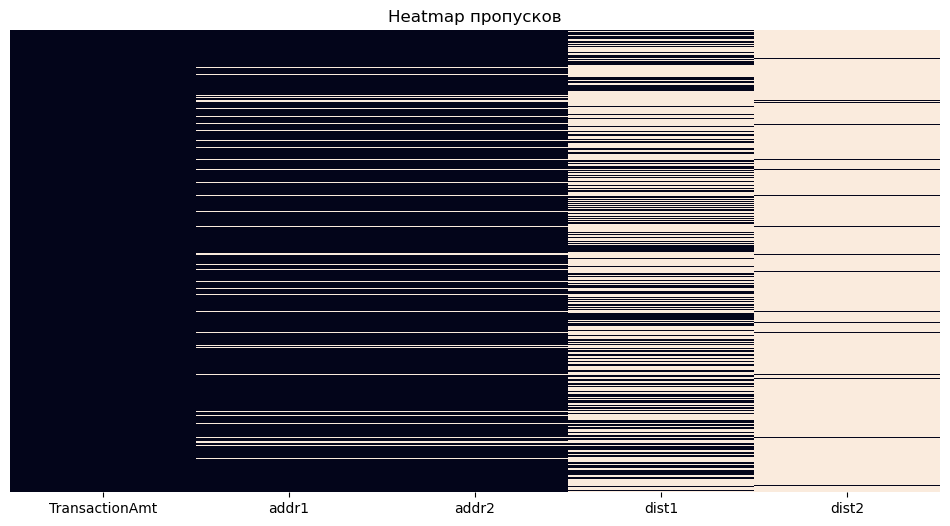

In [392]:
missing_values_report(df_train, num_cols_1)

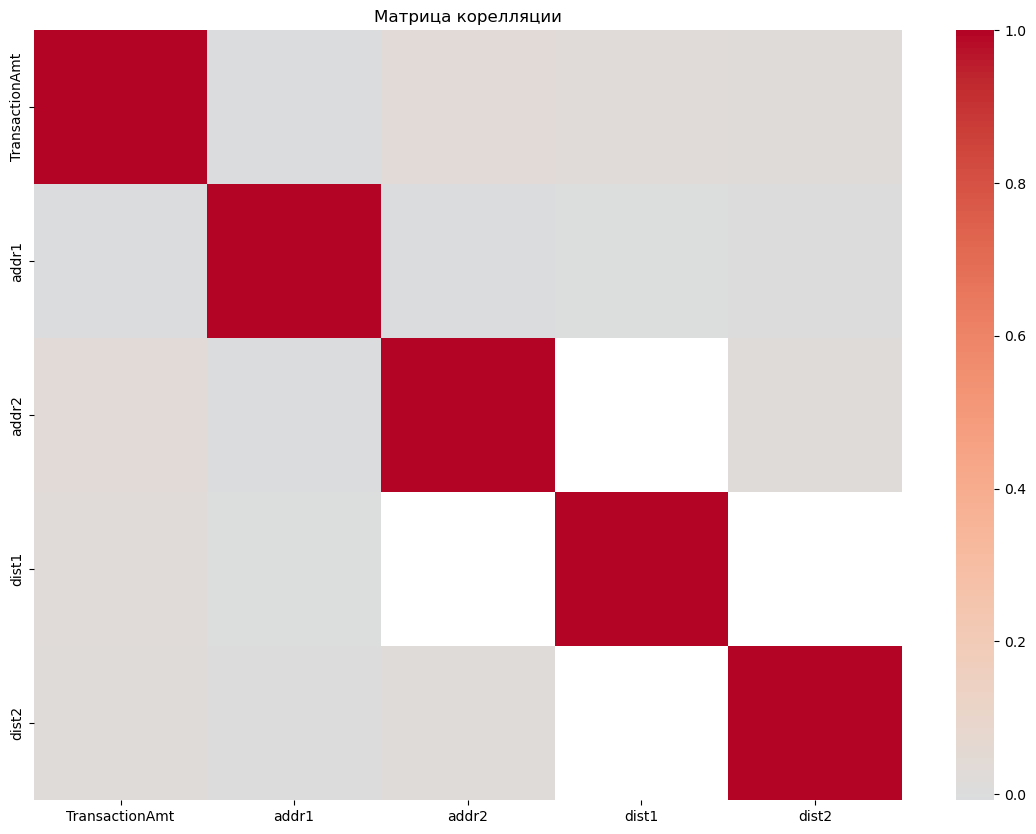

In [393]:
corr_plot(df_train, num_cols_1)

/var/folders/1l/pqz7l_2x14sddt6yj80vz_k80000gn/T/ipykernel_40612/3599314886.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr.values, y=target_corr.index, palette='coolwarm')


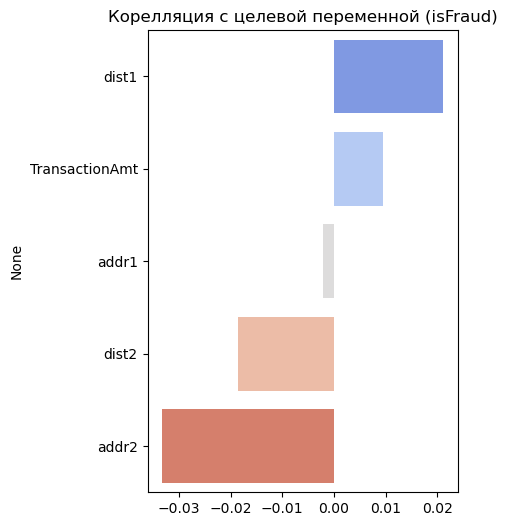

dist1             0.021164
TransactionAmt    0.009483
addr1            -0.002122
dist2            -0.018474
addr2            -0.033326
dtype: float64

In [394]:
target_corr(df_train, num_cols_1)

**Выводы:** корелляции между признаками нет, но и связь с таргетом они не демонстрируют, предлагаю удалить

In [395]:
df_train = df_train.drop(columns=num_cols_1)
df_test = df_test.drop(columns=num_cols_1)

##### Группа 2

In [396]:
num_cols_2 = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']

In [397]:
df_train[num_cols_2].describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000,417559.000000
mean,15.878633,17.381448,0.005697,5.053604,5.305645,9.918934,3.889443,6.703632,4.233138,6.842801,11.512876,5.514311,32.560172,8.768236
std,154.581684,179.413789,0.152001,78.368275,24.868068,80.627847,73.345155,112.656796,16.184631,112.988469,108.556643,102.952404,137.584341,54.828081
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,1.000000
75%,3.000000,3.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,2.000000,1.000000,2.000000,0.000000,11.000000,2.000000
max,4685.000000,5691.000000,24.000000,2253.000000,349.000000,2253.000000,2255.000000,3331.000000,210.000000,3257.000000,3188.000000,3188.000000,2918.000000,1429.000000


Количество пропусков:


,abs,percent


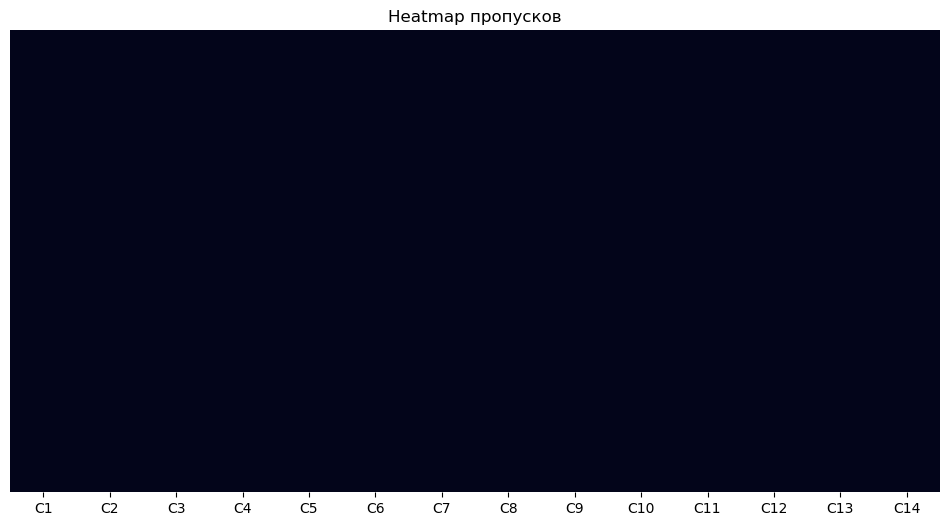

In [398]:
missing_values_report(df_train, num_cols_2)

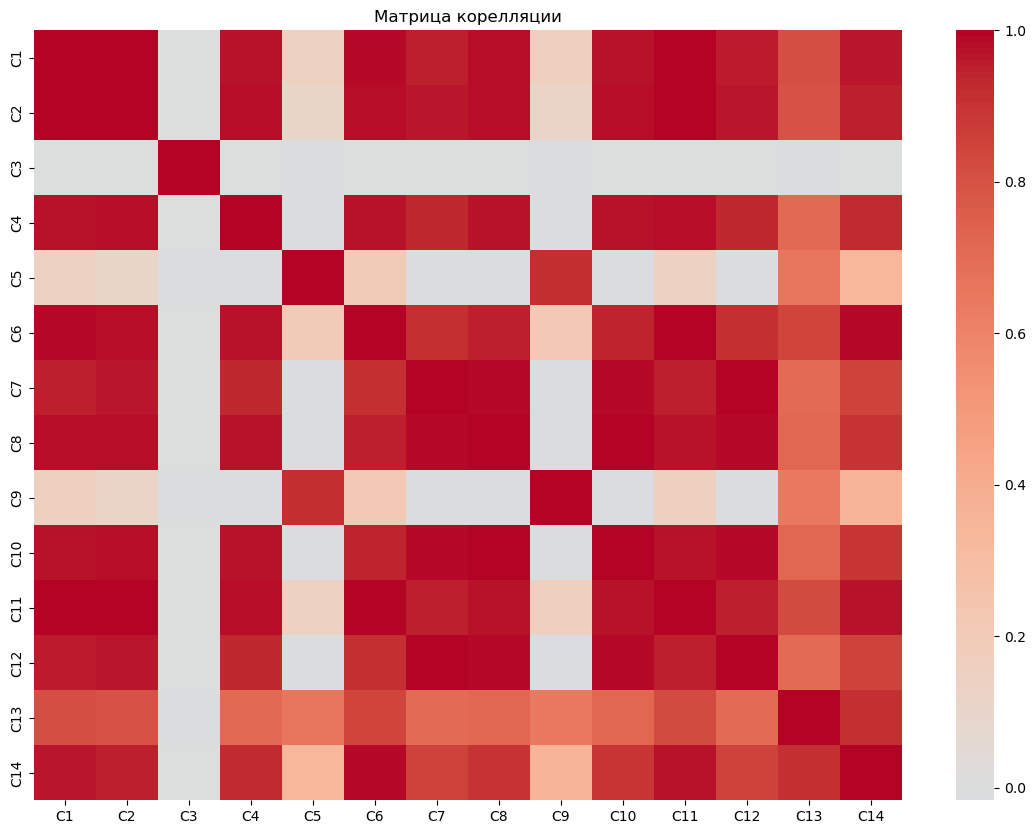

In [399]:
corr_plot(df_train, num_cols_2)

/var/folders/1l/pqz7l_2x14sddt6yj80vz_k80000gn/T/ipykernel_40612/3599314886.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr.values, y=target_corr.index, palette='coolwarm')


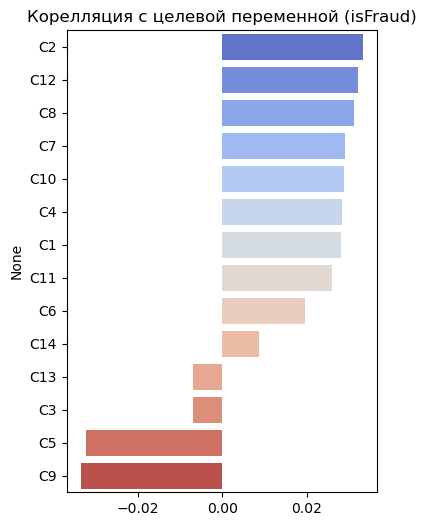

C2     0.033193
C12    0.032083
C8     0.031205
C7     0.029084
C10    0.028854
C4     0.028295
C1     0.027952
C11    0.025834
C6     0.019514
C14    0.008603
C13   -0.006961
C3    -0.007080
C5    -0.032297
C9    -0.033529
dtype: float64

In [400]:
target_corr(df_train, num_cols_2)

**Выводы:** наблюдаем сильную корелляцию между признаками, предлагаю оставить `C3`, `C5`, `C9`  и проверить их на выбросы - судя по describe они должны быть, заполнение пропущенных значений не требуется.

In [401]:
df_train = df_train.drop(columns=['C1', 'C2', 'C4', 'C6', 'C7', 'C8', 'C10', 'C11', 'C12', 'C13', 'C14'])
df_test = df_test.drop(columns=['C1', 'C2', 'C4', 'C6', 'C7', 'C8', 'C10', 'C11', 'C12', 'C13', 'C14'])

<Axes: >

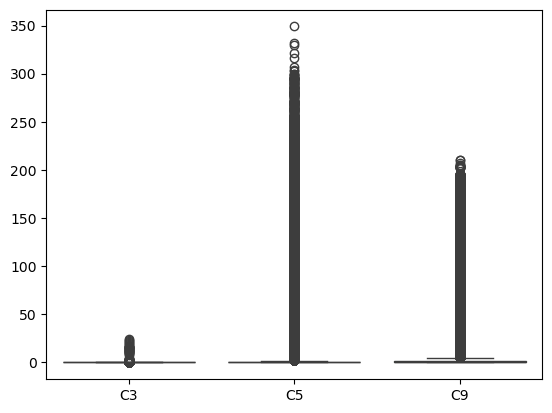

In [402]:
sns.boxplot(data=df_train[['C3', 'C5', 'C9']])

##### Группа 3

In [403]:
num_cols_3 = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15']

In [404]:
df_train[num_cols_3].describe()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
count,417285.000000,209370.000000,221105.000000,294503.000000,191724.000000,53060.000000,26946.000000,56554.000000,56554.000000,356071.000000,190758.000000,47757.000000,44466.000000,45340.000000,348923.000000
mean,87.915537,165.472594,28.591457,131.559512,42.356732,61.860083,44.416500,150.797633,0.561557,115.441991,131.760445,50.620160,16.791594,50.116123,152.884949
std,150.323306,171.049644,62.184351,181.439965,87.970645,135.599036,102.418904,237.205705,0.318679,173.103882,173.091782,117.923324,66.337388,126.813592,192.086861
min,0.000000,0.000000,0.000000,-122.000000,0.000000,-83.000000,0.000000,0.000000,0.000000,0.000000,-53.000000,-83.000000,0.000000,-193.000000,-83.000000
25%,0.000000,23.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.958333,0.208333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,97.000000,8.000000,19.000000,9.000000,0.000000,0.000000,41.604166,0.666666,9.000000,29.000000,0.000000,0.000000,0.000000,41.000000
75%,110.000000,274.000000,27.000000,242.000000,32.000000,20.000000,20.000000,192.916672,0.833333,182.000000,246.000000,9.000000,0.000000,0.000000,296.000000
max,640.000000,640.000000,689.000000,812.000000,775.000000,815.000000,770.000000,1707.791626,0.958333,815.000000,611.000000,600.000000,797.000000,799.000000,815.000000


Количество пропусков:


,abs,percent
D7,390613,93.5
D13,373093,89.4
D14,372219,89.1
D12,369802,88.6
D6,364499,87.3
D8,361005,86.5
D9,361005,86.5
D11,226801,54.3
D5,225835,54.1
D2,208189,49.9


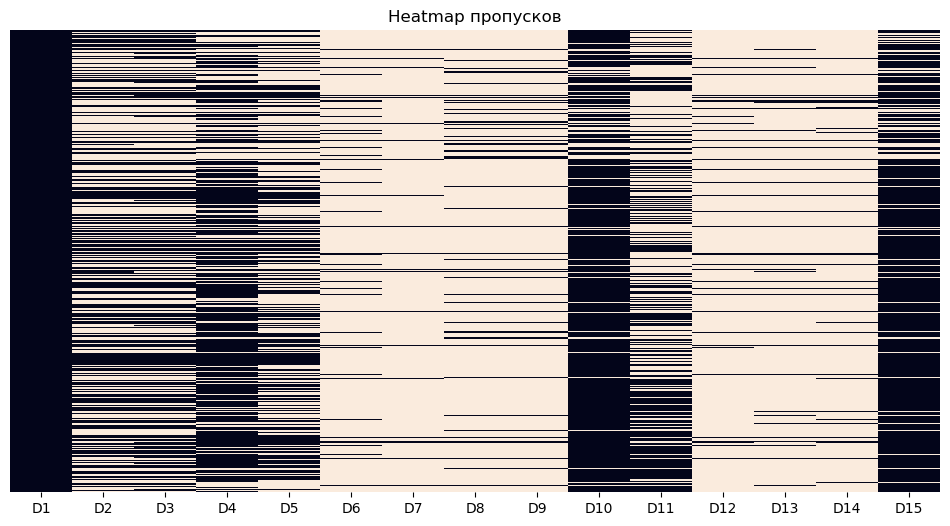

In [405]:
missing_values_report(df_train, num_cols_3)

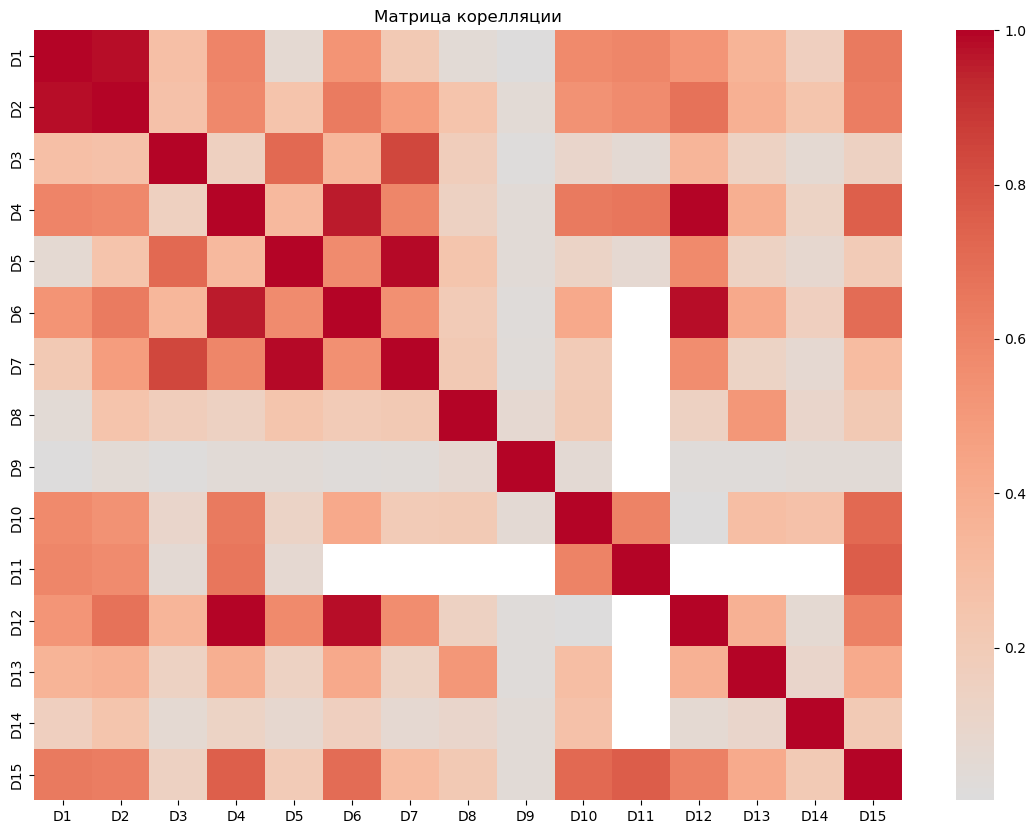

In [406]:
corr_plot(df_train, num_cols_3)

/var/folders/1l/pqz7l_2x14sddt6yj80vz_k80000gn/T/ipykernel_40612/3599314886.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr.values, y=target_corr.index, palette='coolwarm')


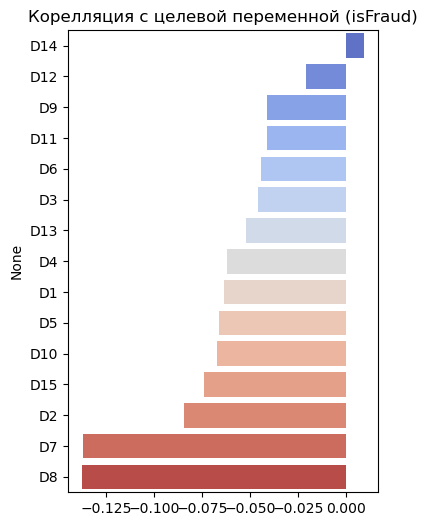

D14    0.008978
D12   -0.020999
D9    -0.041155
D11   -0.041204
D6    -0.044256
D3    -0.045770
D13   -0.052351
D4    -0.061985
D1    -0.063565
D5    -0.066162
D10   -0.067411
D15   -0.074128
D2    -0.084425
D7    -0.137091
D8    -0.137670
dtype: float64

In [407]:
target_corr(df_train, num_cols_3)

**Выводы:** отобрал по степени корелляции с таргетом три признака: `D2`, `D7`, `D8`, `D10`, `D15`. Пропуски заполним медианным значением из трейна (время - дискретная величина).

In [408]:
df_train = df_train.drop(columns=['D1', 'D3', 'D4', 'D5', 'D6', 'D9', 'D11', 'D12', 'D13', 'D14'])
df_test = df_test.drop(columns=['D1', 'D3', 'D4', 'D5', 'D6', 'D9', 'D11', 'D12', 'D13', 'D14'])

median = df_train['D2'].median()
df_train['D2'] = df_train['D2'].fillna(median)
df_test['D2'] = df_test['D2'].fillna(median)

median = df_train['D7'].median()
df_train['D7'] = df_train['D7'].fillna(median)
df_test['D7'] = df_test['D7'].fillna(median)

median = df_train['D8'].median()
df_train['D8'] = df_train['D8'].fillna(median)
df_test['D8'] = df_test['D8'].fillna(median)

median = df_train['D10'].median()
df_train['D10'] = df_train['D10'].fillna(median)
df_test['D10'] = df_test['D10'].fillna(median)

median = df_train['D15'].median()
df_train['D15'] = df_train['D15'].fillna(median)
df_test['D15'] = df_test['D15'].fillna(median)

##### Группа 4

In [409]:
num_cols_4 = ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_13', 'id_14', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_24', 'id_25', 'id_26', 'id_32']

In [410]:
df_train[num_cols_4].describe()

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,110666.000000,108160.000000,49500.000000,49500.000000,105299.000000,105299.000000,3945.000000,3945.000000,56554.00000,56554.000000,...,107259.000000,34269.000000,107226.000000,107209.000000,3950.000000,3954.000000,3624.000000,3930.000000,3948.000000,62116.000000
mean,-9.842291,167481.837047,0.066848,-0.055596,1.754034,-6.582437,13.969582,-38.919138,0.10719,-0.311119,...,187.936416,14.172547,352.299619,400.498661,371.863038,15.991148,12.790563,328.534351,148.645643,26.635327
std,14.249392,149605.267904,0.589575,0.676316,5.284671,16.491670,11.318059,26.020837,0.94671,2.829386,...,30.118252,1.479054,140.265671,150.423924,200.186906,6.891239,2.189355,98.821070,32.355822,3.787343
min,-100.000000,30.000000,-12.000000,-28.000000,-72.000000,-100.000000,-46.000000,-100.000000,-36.00000,-100.000000,...,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,-10.000000,69130.750000,0.000000,0.000000,0.000000,-5.000000,5.000000,-49.000000,0.00000,0.000000,...,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000
50%,-5.000000,122122.000000,0.000000,0.000000,0.000000,0.000000,14.000000,-34.000000,0.00000,0.000000,...,166.000000,15.000000,341.000000,469.000000,252.000000,14.000000,11.000000,321.000000,147.000000,24.000000
75%,-5.000000,215133.750000,0.000000,0.000000,1.000000,0.000000,22.000000,-23.000000,0.00000,0.000000,...,225.000000,15.000000,427.000000,521.000000,500.000000,14.000000,15.000000,371.000000,169.000000,32.000000
max,0.000000,999595.000000,10.000000,0.000000,52.000000,0.000000,61.000000,0.000000,25.00000,0.000000,...,229.000000,29.000000,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000


Количество пропусков:


,abs,percent
id_24,413935,99.1
id_25,413629,99.1
id_07,413614,99.1
id_08,413614,99.1
id_26,413611,99.1
id_21,413609,99.1
id_22,413605,99.1
id_18,383290,91.8
id_03,368059,88.1
id_04,368059,88.1


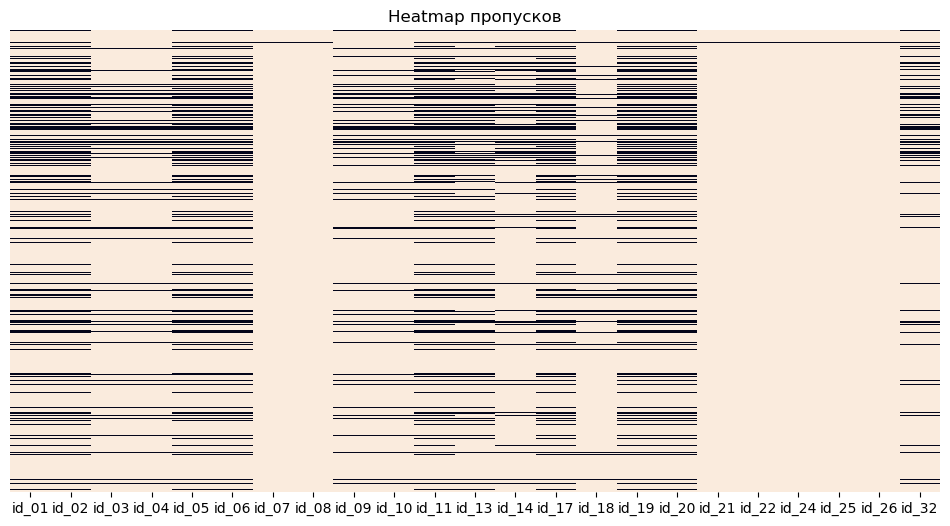

In [411]:
missing_values_report(df_train, num_cols_4)

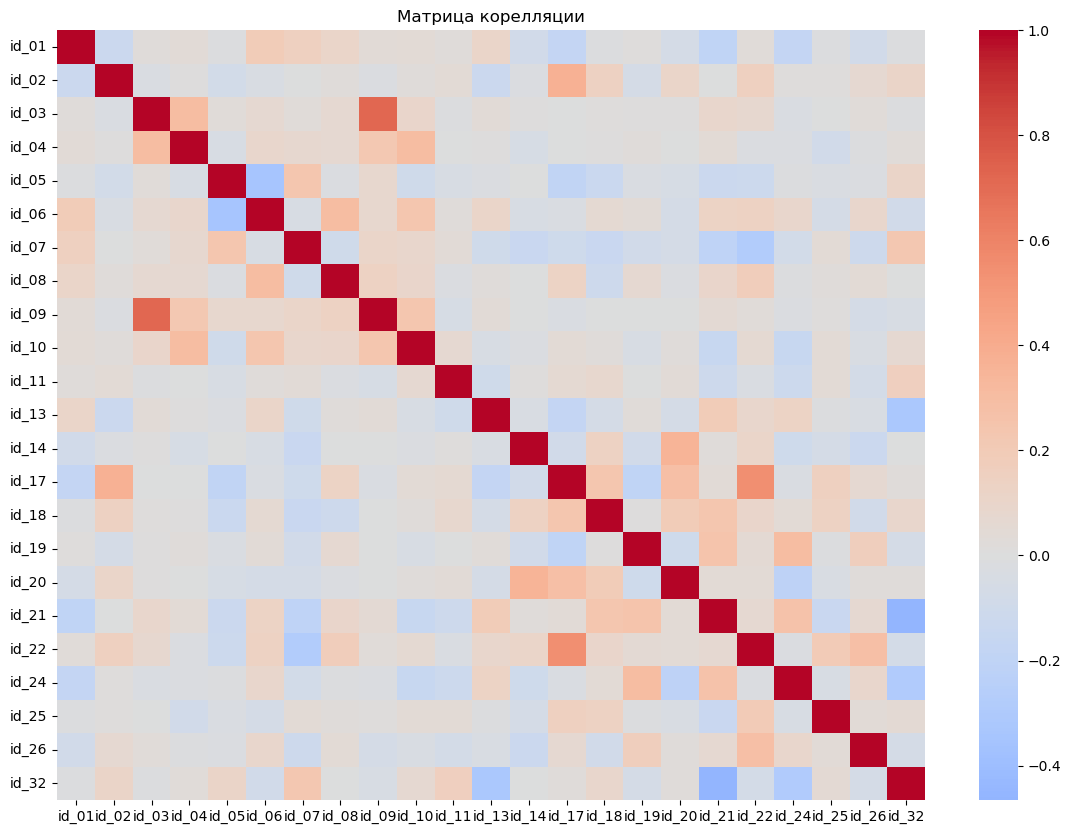

In [412]:
corr_plot(df_train, num_cols_4)

/var/folders/1l/pqz7l_2x14sddt6yj80vz_k80000gn/T/ipykernel_40612/3599314886.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr.values, y=target_corr.index, palette='coolwarm')


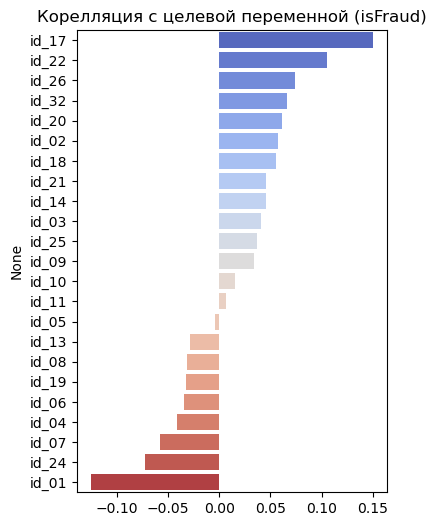

id_17    0.150022
id_22    0.105125
id_26    0.073745
id_32    0.066338
id_20    0.061558
id_02    0.057763
id_18    0.055578
id_21    0.045967
id_14    0.045428
id_03    0.041181
id_25    0.037179
id_09    0.033861
id_10    0.015271
id_11    0.006608
id_05   -0.004051
id_13   -0.028871
id_08   -0.031728
id_19   -0.032266
id_06   -0.034635
id_04   -0.041672
id_07   -0.057823
id_24   -0.072429
id_01   -0.125627
dtype: float64

In [413]:
values = target_corr(df_train, num_cols_4)
values

**Выводы:** продолжая следовать принципу, оставим признаки `id_01`, `id_07`, `id_17`, `id_20`, `id_22`, `id_24`, `id_26`, `id_32`. Пропуски заполним медианными значениями.

In [414]:
save_list = ['id_01', 'id_07', 'id_17', 'id_20', 'id_22', 'id_24', 'id_26', 'id_32']
to_del = [i for i in (set(num_cols_4) - set(save_list))]

df_train = df_train.drop(columns=to_del)
df_test = df_test.drop(columns=to_del)

median = df_train['D2'].median()
df_train['D2'] = df_train['D2'].fillna(median)
df_test['D2'] = df_test['D2'].fillna(median)

median = df_train['id_01'].median()
df_train['id_01'] = df_train['id_01'].fillna(median)
df_test['id_01'] = df_test['id_01'].fillna(median)

median = df_train['id_07'].median()
df_train['id_07'] = df_train['id_07'].fillna(median)
df_test['id_07'] = df_test['id_07'].fillna(median)

median = df_train['id_17'].median()
df_train['id_17'] = df_train['id_17'].fillna(median)
df_test['id_17'] = df_test['id_17'].fillna(median)

median = df_train['id_20'].median()
df_train['id_20'] = df_train['id_20'].fillna(median)
df_test['id_20'] = df_test['id_20'].fillna(median)

median = df_train['id_22'].median()
df_train['id_22'] = df_train['id_22'].fillna(median)
df_test['id_22'] = df_test['id_22'].fillna(median)

median = df_train['id_24'].median()
df_train['id_24'] = df_train['id_24'].fillna(median)
df_test['id_24'] = df_test['id_24'].fillna(median)

median = df_train['id_26'].median()
df_train['id_26'] = df_train['id_26'].fillna(median)
df_test['id_26'] = df_test['id_26'].fillna(median)

median = df_train['id_32'].median()
df_train['id_32'] = df_train['id_32'].fillna(median)
df_test['id_32'] = df_test['id_32'].fillna(median)

##### Группа 5

In [415]:
num_cols_5 = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25',  'V26',  'V27',  'V28',  'V29',  'V30',  'V31',  'V32',  'V33',  'V34', 'V35', 'V36', 'V37', 'V38', 'V39',  'V40',  'V41',  'V42', 'V43', 'V44', 'V45',  'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53',  'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82',  'V83',  'V84',  'V85',  'V86',  'V87',  'V88',  'V89',  'V90',  'V91',  'V92',  'V93',  'V94',  'V95',  'V96',  'V97',  'V98',  'V99',  'V100',  'V101',  'V102',  'V103',  'V104',  'V105',  'V106',  'V107',  'V108',  'V109',  'V110',  'V111',  'V112',  'V113',  'V114',  'V115',  'V116',  'V117',  'V118',  'V119',  'V120',  'V121',  'V122',  'V123',  'V124',  'V125',  'V126',  'V127',  'V128',  'V129',  'V130',  'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145',  'V146',  'V147',  'V148',  'V149',  'V150',  'V151',  'V152',  'V153',  'V154',  'V155',  'V156',  'V157',  'V158',  'V159',  'V160',  'V161',  'V162',  'V163',  'V164',  'V165',  'V166',  'V167',  'V168',  'V169',  'V170',  'V171',  'V172',  'V173',  'V174',  'V175',  'V176',  'V177',  'V178',  'V179',  'V180',  'V181',  'V182',  'V183',  'V184',  'V185',  'V186',  'V187',  'V188',  'V189',  'V190',  'V191',  'V192',  'V193',  'V194',  'V195',  'V196',  'V197',  'V198',  'V199',  'V200',  'V201',  'V202',  'V203',  'V204',  'V205',  'V206',  'V207',  'V208',  'V209',  'V210',  'V211',  'V212',  'V213',  'V214',  'V215',  'V216',  'V217',  'V218',  'V219',  'V220',  'V221',  'V222',  'V223',  'V224',  'V225',  'V226',  'V227',  'V228',  'V229',  'V230',  'V231',  'V232',  'V233',  'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V240', 'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251', 'V252', 'V253',  'V254',  'V255',  'V256',  'V257',  'V258',  'V259',  'V260',  'V261',  'V262',  'V263',  'V264',  'V265',  'V266',  'V267',  'V268',  'V269',  'V270',  'V271',  'V272',  'V273',  'V274',  'V275',  'V276',  'V277',  'V278',  'V279',  'V280',  'V281',  'V282',  'V283',  'V284',  'V285',  'V286',  'V287',  'V288',  'V289',  'V290',  'V291',  'V292',  'V293',  'V294',  'V295',  'V296',  'V297',  'V298',  'V299',  'V300',  'V301',  'V302',  'V303',  'V304',  'V305',  'V306',  'V307',  'V308',  'V309',  'V310',  'V311',  'V312',  'V313',  'V314',  'V315',  'V316',  'V317',  'V318',  'V319',  'V320',  'V321',  'V322',  'V323',  'V324',  'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339']

In [416]:
df_train[num_cols_5].describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,190758.000000,190758.000000,190758.000000,190758.000000,190758.000000,190758.000000,190758.000000,190758.000000,190758.000000,190758.000000,...,65788.000000,65788.000000,65788.000000,65788.000000,65788.000000,65788.00000,65788.000000,65788.000000,65788.000000,65788.000000
mean,0.999963,1.039139,1.070078,0.840982,0.871827,1.040444,1.065858,1.023774,1.036822,0.454524,...,0.158722,77.829650,107.412405,89.193635,9.446533,24.92069,14.373174,29.492255,35.068630,31.341346
std,0.006058,0.217811,0.298151,0.434544,0.471470,0.220908,0.282556,0.166547,0.207577,0.517597,...,0.684353,622.458259,730.979836,644.943251,271.040670,316.44272,276.073416,298.446862,322.547934,303.147239
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,1.000000,6.000000,6.000000,5.000000,6.000000,6.000000,7.000000,6.000000,6.000000,4.000000,...,15.000000,55125.000000,55125.000000,55125.000000,55125.000000,55125.00000,55125.000000,25000.000000,25000.000000,25000.000000


Количество пропусков:


,abs,percent
V166,352063,84.3
V152,352063,84.3
V140,352063,84.3
V141,352063,84.3
V142,352063,84.3
...,...,...
V307,12,0.0
V308,12,0.0
V309,12,0.0
V310,12,0.0


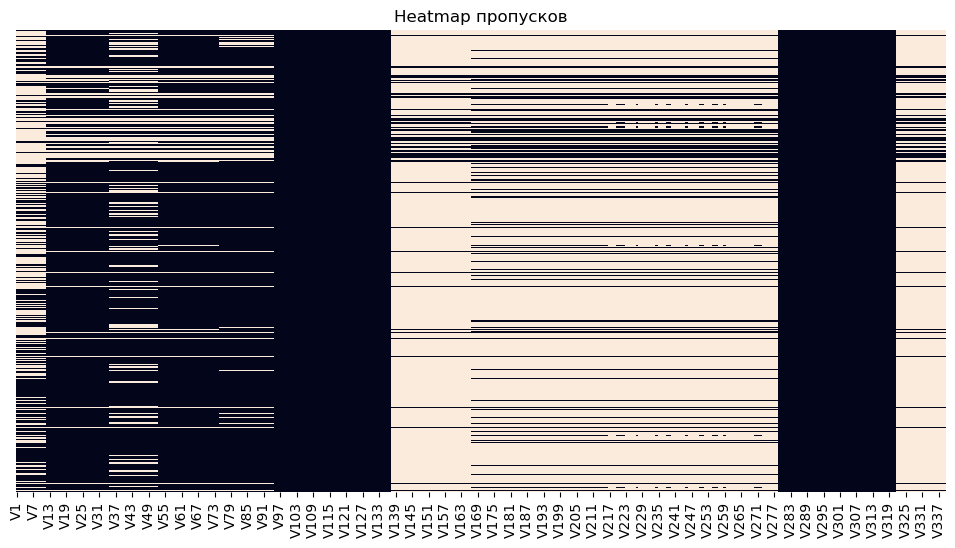

In [417]:
missing_values_report(df_train, num_cols_5)

/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/1l/pqz7l_2x14sddt6yj80vz_k80000gn/T/ipykernel_40612/3599314886.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr.values, y=target_corr.index, palette='coolwarm')


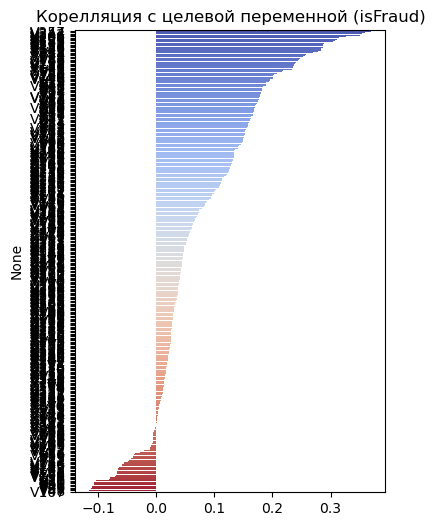

,0
V257,0.369941
V244,0.359899
V242,0.354488
V246,0.351318
V201,0.326478
V200,0.313537
V233,0.310822
V188,0.307764
V189,0.303891
V232,0.288307


In [418]:
result = pd.DataFrame(target_corr(df_train, num_cols_5))
result.head(20)

**Выводы:** из чувства рациональности по времени грядущего обучения предлагаю оставить 20 самых кореллирующих с таргетом признаков, пропуски заполним медианным значением.

In [419]:
save_list = result.iloc[:20,:].index.to_list()
to_del = [i for i in (set(num_cols_5) - set(save_list))]

df_train = df_train.drop(columns=to_del)
df_test = df_test.drop(columns=to_del)

def median_fill(df_train, df_test, columns_list):
    for i in columns_list:
        median = df_train[i].median()
        df_train[i] = df_train[i].fillna(median)
        df_test[i] = df_test[i].fillna(median)

median_fill(df_train, df_test, save_list)

# **Задание 2 (3 балла)**

Обучите несколько ML-моделей для решения поставленной задачи.
Оцените их качество двумя способами:

1) на кросс-валидации

2) на лидерборде

Подберите число фолдов на кросс-валидации так, чтобы метрики, которые вы видите, были максимально близки на кросс-валидации и на лидерборде.

По результатам экспериментов постройте таблицу:
* в каждой строке таблицы - результаты одной модели
* по столбцам: качество на кросс-валидации, качество на лидерборде, модель с гиперпараметрами
Полученную таблицу вставьте картинкой прямо в ноутбук после ячеек с кодом. Сделайте текстовые выводы.

#### 1. Перепроверка бейзлайна

Посмотрим, насколько качественно мы провели EDA: логически мы ожидаем, что если мы не выкинули очень важные признаки и правильно заполнили пропуски, то качество модели упасть не должно

In [14]:
cat_features = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
cols_in_df = df_train.columns.drop('isFraud')
cat_features_idx = [df_train.columns.drop('isFraud').get_loc(col) for col in cat_features if col in cols_in_df]
cat_features_idx

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 12,
 13,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 402,
 405,
 406,
 413,
 417,
 418,
 419,
 420,
 421,
 423,
 424,
 425,
 426,
 427,
 428,
 429,
 430]

In [436]:
X_train = df_train.drop('isFraud', axis=1)
y_train = df_train['isFraud'].values

#так делаю, потому что в условиях указано, что card - категориальные признаки, а catboost ругается на floats
for col in cat_features:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype(str).fillna("missing")
        df_test[col] = df_test[col].astype(str).fillna("missing")

cb = CatBoostClassifier(iterations=3)
cb.fit(X_train, y_train, cat_features_idx, )

predictions = cb.predict_proba(df_test)

sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions[:, 0]})
sub.head()

sub.to_csv('submission_baseline.csv', index=False)

Learning rate set to 0.5
0:	learn: 0.2199488	total: 197ms	remaining: 394ms
1:	learn: 0.1416372	total: 401ms	remaining: 201ms
2:	learn: 0.1236689	total: 576ms	remaining: 0us


![baseline_check](https://storage.yandexcloud.net/infections-project-datasets/sub_baseline_check.png)

**Качество выросло, но не спешим радоваться, пока оно не 0.5 и выше**

#### 2. Тюнинг catboost

Далее проведем тюнинг catboost и для лучшей модели будем подбирать количество фолдов для CV, чтобы качество было сопоставимо с liderboard. Единственное, в CV мы должны будем сохранять соотношение классов с исходной выборкой для релевантности.

In [439]:
!pip install optuna

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.11.0
    Uninstalling typing_extensions-4.11.0:
      Successfully uninstalled typing_extensions-4.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.12.3 requires botocore<1.34.70,>=1.34.41, but you have botocore 1.35.50 which is incompatible.


In [450]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


def objective(trial):
    depth = trial.suggest_int("depth", 4, 10)
    lr = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    
    cb = CatBoostClassifier(iterations=3, depth=depth, learning_rate=lr, eval_metric="AUC")
    
    
    cb.fit(X_tr, y_tr, cat_features_idx, eval_set=(X_val, y_val), use_best_model=True, )
    preds = cb.predict_proba(X_val)[:, 1]
    
    return roc_auc_score(y_val, preds)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

print("Лучшие параметры:", study.best_params)
print("Лучший ROC-AUC:", study.best_value)

[I 2025-10-01 16:33:55,866] A new study created in memory with name: no-name-b739f36c-dea9-4a16-bed7-fe67c5f82f11


0:	test: 0.6255092	best: 0.6255092 (0)	total: 139ms	remaining: 278ms
1:	test: 0.6818862	best: 0.6818862 (1)	total: 237ms	remaining: 119ms


[I 2025-10-01 16:33:57,229] Trial 0 finished with value: 0.6931485312130343 and parameters: {'depth': 5, 'learning_rate': 0.01894996008786399}. Best is trial 0 with value: 0.6931485312130343.


2:	test: 0.6931485	best: 0.6931485 (2)	total: 355ms	remaining: 0us

bestTest = 0.6931485312
bestIteration = 2

0:	test: 0.6832843	best: 0.6832843 (0)	total: 214ms	remaining: 429ms
1:	test: 0.6888974	best: 0.6888974 (1)	total: 361ms	remaining: 180ms


[I 2025-10-01 16:33:58,669] Trial 1 finished with value: 0.7029394437233415 and parameters: {'depth': 9, 'learning_rate': 0.030891516621641905}. Best is trial 1 with value: 0.7029394437233415.


2:	test: 0.7029394	best: 0.7029394 (2)	total: 501ms	remaining: 0us

bestTest = 0.7029394437
bestIteration = 2

0:	test: 0.6838050	best: 0.6838050 (0)	total: 253ms	remaining: 506ms
1:	test: 0.6927422	best: 0.6927422 (1)	total: 488ms	remaining: 244ms
2:	test: 0.6926457	best: 0.6927422 (1)	total: 598ms	remaining: 0us

bestTest = 0.6927421814
bestIteration = 1

Shrink model to first 2 iterations.


[I 2025-10-01 16:34:00,292] Trial 2 finished with value: 0.6927421814121097 and parameters: {'depth': 10, 'learning_rate': 0.11096306847544285}. Best is trial 1 with value: 0.7029394437233415.


0:	test: 0.6402428	best: 0.6402428 (0)	total: 170ms	remaining: 340ms
1:	test: 0.6907485	best: 0.6907485 (1)	total: 313ms	remaining: 156ms


[I 2025-10-01 16:34:01,725] Trial 3 finished with value: 0.7010692620101086 and parameters: {'depth': 8, 'learning_rate': 0.044464832898071856}. Best is trial 1 with value: 0.7029394437233415.


2:	test: 0.7010693	best: 0.7010693 (2)	total: 486ms	remaining: 0us

bestTest = 0.701069262
bestIteration = 2

0:	test: 0.6838050	best: 0.6838050 (0)	total: 226ms	remaining: 452ms
1:	test: 0.6927424	best: 0.6927424 (1)	total: 430ms	remaining: 215ms
2:	test: 0.6956155	best: 0.6956155 (2)	total: 611ms	remaining: 0us

bestTest = 0.6956155412
bestIteration = 2



[I 2025-10-01 16:34:03,268] Trial 4 finished with value: 0.6956155411726199 and parameters: {'depth': 10, 'learning_rate': 0.19110999629085937}. Best is trial 1 with value: 0.7029394437233415.


Лучшие параметры: {'depth': 9, 'learning_rate': 0.030891516621641905}
Лучший ROC-AUC: 0.7029394437233415


In [451]:
cb = CatBoostClassifier(iterations=3, depth=study.best_params['depth'], learning_rate=study.best_params['learning_rate'], eval_metric="AUC")

cb.fit(X_train, y_train, cat_features_idx, )
predictions = cb.predict_proba(df_test)

sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions[:, 0]})
sub.head()

sub.to_csv('submission_baseline.csv', index=False)

0:	total: 114ms	remaining: 228ms
1:	total: 245ms	remaining: 122ms
2:	total: 439ms	remaining: 0us


![baseline_check](https://storage.yandexcloud.net/infections-project-datasets/sub_cat.png)

Очевидно, что модель переобучается, демонстрируя высокое качество на трейне и низкое - на лидерборде.

In [465]:
from catboost import cv, Pool

cv_data = Pool(data=X_train, label=y_train, cat_features=cat_features_idx)

params = {'iterations': 100, 'depth': study.best_params['depth'], 'learning_rate': study.best_params['learning_rate'], 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'verbose': False}

cv_results = cv(cv_data, params, fold_count=5, plot=True)
print(cv_results)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.8656249921
bestIteration = 99

Training on fold [1/5]

bestTest = 0.8678627984
bestIteration = 99

Training on fold [2/5]

bestTest = 0.8676859418
bestIteration = 99

Training on fold [3/5]

bestTest = 0.8702457626
bestIteration = 99

Training on fold [4/5]

bestTest = 0.8667256262
bestIteration = 99

    iterations  test-AUC-mean  test-AUC-std  test-Logloss-mean  \
0            0       0.615528      0.039833           0.643435   
1            1       0.677756      0.040672           0.597375   
2            2       0.724273      0.027809           0.553943   
3            3       0.732088      0.031941           0.516451   
4            4       0.749296      0.017556           0.480757   
..         ...            ...           ...                ...   
95          95       0.866894      0.001622           0.101861   
96          96       0.867186      0.001660           0.101713   
97          97       0.867245      0.001672           0.101602   


In [466]:
cv_results = cv(cv_data, params, fold_count=15, plot=True)
print(cv_results)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/15]

bestTest = 0.8820886472
bestIteration = 99

Training on fold [1/15]

bestTest = 0.8581820096
bestIteration = 99

Training on fold [2/15]

bestTest = 0.8626375822
bestIteration = 99

Training on fold [3/15]

bestTest = 0.8706930855
bestIteration = 99

Training on fold [4/15]

bestTest = 0.8743744453
bestIteration = 99

Training on fold [5/15]

bestTest = 0.8633486424
bestIteration = 99

Training on fold [6/15]

bestTest = 0.8718428098
bestIteration = 99

Training on fold [7/15]

bestTest = 0.8719437559
bestIteration = 99

Training on fold [8/15]

bestTest = 0.8665866841
bestIteration = 99

Training on fold [9/15]

bestTest = 0.8753771388
bestIteration = 99

Training on fold [10/15]

bestTest = 0.8653209574
bestIteration = 99

Training on fold [11/15]

bestTest = 0.8663124841
bestIteration = 99

Training on fold [12/15]

bestTest = 0.8747365987
bestIteration = 99

Training on fold [13/15]

bestTest = 0.8647406666
bestIteration = 99

Training on fold [14/15]

best

#### 2. Обучим XGBoost

In [2]:
import pandas as pd

In [3]:
X_train = pd.read_csv('./df_train.csv')
X_test = pd.read_csv('./df_test.csv')

X_train = X_train.drop(columns='Unnamed: 0')
X_test = X_test.drop(columns='Unnamed: 0')

/var/folders/1l/pqz7l_2x14sddt6yj80vz_k80000gn/T/ipykernel_2768/2226961897.py:1: DtypeWarning: Columns (5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  X_train = pd.read_csv('./df_train.csv')
/var/folders/1l/pqz7l_2x14sddt6yj80vz_k80000gn/T/ipykernel_2768/2226961897.py:2: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  X_test = pd.read_csv('./df_test.csv')


In [4]:
y_train = X_train.isFraud.values
X_train = X_train.drop(columns='isFraud')

In [5]:
print(X_train.shape, X_test.shape)

(417559, 51) (172981, 51)


Закодируем категориальные переменные, используем `TargetEncoder`

In [6]:
cat_features = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

In [7]:
real_cat_features = []
for i in cat_features:
    if i in X_train.columns.to_list():
        real_cat_features.append(i)

In [8]:
import category_encoders as ce

target_encoder = ce.TargetEncoder(cols=real_cat_features)

target_encoder.fit(X_train[real_cat_features], y_train)

X_train_te = X_train.copy()
X_test_te = X_test.copy()

X_train_te[real_cat_features] = target_encoder.transform(X_train[real_cat_features])
X_test_te[real_cat_features] = target_encoder.transform(X_test[real_cat_features])

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train_te)

X_train_te = pd.DataFrame(scaler.transform(X_train_te), columns=X_train_te.columns)
X_test_te  = pd.DataFrame(scaler.transform(X_test_te), columns=X_test_te.columns)

In [14]:
import xgboost as xgb


xgb_cl = xgb.XGBClassifier(max_depth=3, learning_rate=0.3, objective='binary:logistic', n_estimators=20, verbosity=0)

xgb_cl.fit(X_train_te, y_train)
predictions = xgb_cl.predict_proba(X_test_te)

sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions[:, 0]})
sub.head()

sub.to_csv('submission_baseline.csv', index=False)

: 

Не получилось, тк постоянно крашится ядро

# **Задание 3 (2 балла)**

Попробуйте подойти к задаче как к поиску аномалий.

1) Поищите аномалии (фрод) различными рассмотренными в курсе методами и сделайте прогноз на тестовых данных.

Результатом также будет таблица:
* по строкам - методы поиска аномалий
* по столбцам - качество вашего решения на leaderboard

2) Попробуйте встроить поиск аномалий и их удаление в ML-пайплайн: найдите аномалии и что-нибудь с ними сделайте до обучения моделей (можно удалить их, а можно использовать в качестве дополнительных признаков - попробуйте разные стратегии). Результат проверьте на кросс-валидации и на лидерборде, сделайте выводы.

#### 1. Рассмотрим задачу поиска аномалий как задачу бинарной классификации в отношении целевой переменной

##### 1. Найдем аномалии, используя IsolationForest

In [69]:
from sklearn.ensemble import IsolationForest
import numpy as np

rng = np.random.RandomState(42)

clf = IsolationForest(max_samples=100, contamination=0.1, random_state=rng)
clf.fit(X_train_te)

IsolationForest(contamination=0.1, max_samples=100,
                random_state=RandomState(MT19937) at 0x176FC5240)

In [70]:
predictions_train_for = clf.predict(X_train_te)
print(pd.Series(predictions).value_counts())
predictions_for = pd.Series(predictions).apply(lambda x: 1 if x < 0 else 0)
print(pd.Series(predictions_for).value_counts())

0    155665
1     17316
Name: count, dtype: int64
0    172981
Name: count, dtype: int64


In [71]:
predictions_for = clf.predict(X_test_te)
print(pd.Series(predictions).value_counts())
predictions_for = pd.Series(predictions).apply(lambda x: 1 if x < 0 else 0)
print(pd.Series(predictions_for).value_counts())

0    155665
1     17316
Name: count, dtype: int64
0    172981
Name: count, dtype: int64


In [59]:
sample_submission = pd.read_csv('./sample_submission.csv')

In [60]:
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions})
sub.head()

sub.to_csv('submission_baseline.csv', index=False)

![baseline_check](https://storage.yandexcloud.net/infections-project-datasets/sub_iso.png)

##### 2. Найдем аномалии с использованием одноклассового SVM

In [29]:
from sklearn import svm

clf = svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
clf.fit(X_train_te)

In [61]:
pred = clf.predict(X_test_te)

In [62]:
print(pd.Series(pred).value_counts())
predictions = pd.Series(pred).apply(lambda x: 1 if x < 0 else 0)
print(pd.Series(predictions).value_counts())

 1    155665
-1     17316
Name: count, dtype: int64
0    155665
1     17316
Name: count, dtype: int64


In [63]:
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions})
sub.head()

sub.to_csv('submission_baseline.csv', index=False)

![baseline_check](https://storage.yandexcloud.net/infections-project-datasets/sub_iso.png)

#### 2. Попробуем добавить признак аномальности в обучение

##### 1. Для начала добавим признак выброса в тренировочный и в тестовый датасеты

In [ ]:
X_train_out = X_train.copy()
X_test_out = X_test.copy()

X_train_out['outlier'] = 
X_test_out['outlier'] = predictions_for

In [ ]:
cb = CatBoostClassifier(iterations=3, depth=study.best_params['depth'], learning_rate=study.best_params['learning_rate'], eval_metric="AUC")

cb.fit(X_train, y_train, cat_features_idx, )
predictions = cb.predict_proba(df_test)

sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions[:, 0]})
sub.head()

sub.to_csv('submission_baseline.csv', index=False)

# **Задание 4 (1 балл)**

Сделайте кластеризацию различными способами. Результаты кластеризации используйте для улучшения ML-решений:

1) Номера кластеров закодируйте (OHE или target-encoding) и добавьте как новые признаки

2) При использовании DBSCAN / HDBSCAN предсказанный шум можно трактовать как найденную аномалию и также добавить ее как новый признак

Проведите различные эксперименты. Проверьте как эти подходы влияют на качество прогнозов по кросс-валидации и на лидерборде, сделайте выводы.

In [ ]:
# ваши эксперименты с кластеризацией здесь

## **Задание 5 (1 балл)**

Примените какой-нибудь (один любой) AutoML фреймворк для решения поставленной задачи.

Отправьте AutoML-прогноз на kaggle и посмотрите на качество модели. Сделайте текстовые выводы.

In [11]:
!pip install lightautoml

In [12]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

automl = TabularAutoML(task = Task(name = 'binary', metric = 'auc'))
oof_preds = automl.fit_predict(df_train, roles = {'target': 'isFraud'}).data
test_preds = automl.predict_proba(df_test).data

'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


/opt/anaconda3/lib/python3.12/site-packages/lightautoml/ml_algo/dl_model.py:42: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")
/opt/anaconda3/lib/python3.12/site-packages/lightautoml/text/embed.py:22: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")
/opt/anaconda3/lib/python3.12/site-packages/lightautoml/text/dl_transformers.py:25: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")


: 

# **Задание 6 (1 балл)**

Весь курс мы работали в Google Colab. Но всегда должны быть запасные варианты, где Вы будете обучать модели.

Среди вариантов есть:
* ваша локальная машина
* kaggle notebooks
* yandex cloud
и другие.

Кроме привычного Google Colab выберите из списка выше один любой альтернативный вариант и проведите эксперимент:

* Прогоните ваш лучший по качеству по результатам заданий 2-4 ML-пайплайн заново в Google Colab и с помощью библиотек (например, при помощи библиотеки time) замерьте время обучения и отдельно время инференса на тестовых данных

* Прогоните этот пайплайн на выбранном альтернативном сервисе/локальной машине и также замерьте время обучения и инференса.

Текстом напишите выводы: опишите, какое альтернативное место для обучения моделей Вы использовали? Прикрепите прямо в ноутбук скриншот с экраном кода в альтернативном сервисе/на локальной машине. Также в виде таблицы приведите сравнение времени обучения и инференса в колабе и в альтернативном месте. Сделайте выводы.

In [ ]:
# ваши эксперименты здесь

# **Бонус: за Kaggle и стремление к хорошим скорам (2 балла)**

В этом домашнем задании Ваша цель - не просто выполнить шаги выше, но и построить максимально хорошую по качеству модель.

**К 10 вы можете получить до двух дополнительных баллов:**

* За попадание в топ-20% на private leaderboard — +1 дополнительный балл к оценке
* За попадание в топ-5 мест на private leaderboard — + еще один дополнительный балл к оценке (то есть суммарно 2 дополнительных балла)

**ВАЖНО!!!**

Эти баллы ставятся до мягкого дедлайна по соревнованию. После мягкого дедлайна лидерборд не обновляется, и дополнительные баллы не ставятся.

Успехов!

In [ ]:
# не забудьте прикрепить скриншоты лидерборда, пожалуйста